In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

project_path = "/content/drive/MyDrive/Colab Notebooks"
os.chdir(project_path)

print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:
import pandas as pd
from datetime import datetime

import yfinance as yf
stock_data = yf.download('TSLA', start='2024-01-01', end='2026-01-01')
stock_data.to_csv('data_storage/stock_prices.csv')

# Load your daily sentiment data
daily_df = pd.read_csv("data_storage/daily_sent_features.csv")
daily_df['date'] = pd.to_datetime(daily_df['date']).dt.date

stock_df = pd.read_csv("data_storage/stock_prices.csv")
# the first 2 index values are actually extra column name values
stock_df = stock_df.iloc[2:].reset_index(drop=True)
# Assign new column names
stock_df.columns = ['date', 'Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA']

# Convert all columns except 'date' to numeric
cols_to_numeric = [col for col in stock_df.columns if col != 'date']
stock_df[cols_to_numeric] = stock_df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Also create date column for merging
stock_df['date'] = pd.to_datetime(stock_df['date']).dt.date

print(daily_df.head())
print(stock_df.head())

/tmp/ipython-input-1859239133.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download('TSLA', start='2024-01-01', end='2026-01-01')
[*********************100%***********************]  1 of 1 completed


         date  avg_sentiment  avg_sentiment_ma7  article_count  \
0  2024-01-24      -0.057471          -0.009703             76   
1  2024-01-25      -0.175297          -0.025078             59   
2  2024-01-26      -0.163414          -0.046786             57   
3  2024-01-27      -0.206962          -0.093412             17   
4  2024-01-28      -0.054269          -0.104522             16   

   article_count_ma7  avg_sentiment_lag1  article_count_lag1  \
0          36.714286           -0.013149                34.0   
1          37.142857           -0.057471                76.0   
2          40.714286           -0.175297                59.0   
3          42.142857           -0.163414                57.0   
4          42.714286           -0.206962                17.0   

   latest_earnings_sentiment  
0                   0.077734  
1                   0.077734  
2                   0.077734  
3                   0.077734  
4                   0.077734  
         date  Close_TSLA   High

Here, we will calculate the percentage change between yesterdays and today's closing numbers for TSLA.  We will add this as a new feature for prediction.

We also need to create the variable we are predicting for though which is whether the stock price will increase or decrease tomorrow.  We will call this variable 'target'.

I will also add in the rolling average of the last 5 days of percentage change in closing price, as well as the volume change.

In [ ]:
# Create daily return (price change %)
stock_df['return'] = stock_df['Close_TSLA'].pct_change()
stock_df['return_5d'] = stock_df['Close_TSLA'].pct_change(5)

# Target: 1 if price goes UP tomorrow, 0 if DOWN tomorrow
stock_df['target'] = (stock_df['return_5d'].shift(-5) > 0).astype(int)

# 5-day moving average of returns (price trend)
stock_df['return_ma5'] = stock_df['return'].rolling(5).mean()

# Volume change
stock_df['volume_change'] = stock_df['Volume_TSLA'].pct_change()

# print(stock_df[['date', 'Close_TSLA', 'return', 'return_5d', 'return_ma5', 'volume_change', 'target']].head(10))

In [ ]:
stock_df = stock_df[['date', 'Close_TSLA', 'return', 'return_5d', 'return_ma5', 'volume_change', 'target']]

print(f"Stock dataset: {len(stock_df)} rows")
print(f"Article dataset: {len(daily_df)} rows")
# Merge on date
merged_df = stock_df.merge(daily_df, on='date', how='inner')

# Drop any rows with NaN (from moving averages, lags, or last row target)
merged_df = merged_df.dropna()

print(f"Merged dataset: {len(merged_df)} rows")
print(merged_df.head())

# -----------------------------
# Save to CSV
# -----------------------------
merged_df.to_csv("data_storage/data_for_stock_prediction.csv", index=False)

Stock dataset: 502 rows
Article dataset: 709 rows
Merged dataset: 487 rows
         date  Close_TSLA    return  return_5d  return_ma5  volume_change  \
0  2024-01-24  207.830002 -0.006264  -0.035815   -0.007235       0.157252   
1  2024-01-25  182.630005 -0.121253  -0.138050   -0.028080       0.605552   
2  2024-01-26  183.250000  0.003395  -0.136387   -0.027694      -0.458073   
3  2024-01-29  190.929993  0.041910  -0.085584   -0.016117       0.164611   
4  2024-01-30  191.589996  0.003457  -0.083915   -0.015751      -0.120234   

   target  avg_sentiment  avg_sentiment_ma7  article_count  article_count_ma7  \
0       0      -0.057471          -0.009703             76          36.714286   
1       1      -0.175297          -0.025078             59          37.142857   
2       1      -0.163414          -0.046786             57          40.714286   
3       0      -0.004313          -0.096411             47          43.714286   
4       0      -0.352734          -0.144923             5

In [ ]:
# Look at date gaps
stock_df['date_diff'] = stock_df['date'].diff().dt.days

print("Date gaps (should mostly be 1, with 3 for weekends):")
print(stock_df['date_diff'].value_counts())

# Find large gaps (>3 days)
print("\nLarge gaps (potential issues):")
print(stock_df[stock_df['date_diff'] > 3][['date', 'date_diff']])

Date gaps (should mostly be 1, with 3 for weekends):
date_diff
1.0    388
3.0     93
4.0     11
2.0      9
Name: count, dtype: int64

Large gaps (potential issues):
           date  date_diff
9    2024-01-16        4.0
33   2024-02-20        4.0
61   2024-04-01        4.0
101  2024-05-28        4.0
168  2024-09-03        4.0
263  2025-01-21        4.0
282  2025-02-18        4.0
325  2025-04-21        4.0
350  2025-05-27        4.0
377  2025-07-07        4.0
417  2025-09-02        4.0


I was just checking why the 2 data sets didn't merge to create more than 700 days.  It's because there are less than 365 trading days in a year.  There are no trades on weekends and holidays.

The above analysis shows gaps occur on weekends and holidays listed here:
https://www.tsx.com/en/resource/3086

Next we need to split train and testing.

In [ ]:
# # Ensure datetime
# merged_df['date'] = pd.to_datetime(merged_df['date'])

# # Sort chronologically
# merged_df = merged_df.sort_values('date').reset_index(drop=True)

# # before split we will create the interaction terms for interpretability
# merged_df['interaction'] = (
#     merged_df['avg_sentiment'] * merged_df['article_count']
# )

# merged_df['interaction_ma7'] = (
#     merged_df['avg_sentiment_ma7'] * merged_df['article_count_ma7']
# )


# # Define cutoff dates
# train_cutoff = pd.Timestamp('2025-02-01')
# test_start   = pd.Timestamp('2025-02-08')  # 7 day buffer due to data leakage

# # Split
# train_df = merged_df[merged_df['date'] < train_cutoff].copy()
# test_df  = merged_df[merged_df['date'] >= test_start].copy()

# # Sanity check
# print("Train shape:", train_df.shape)
# print("Test shape:", test_df.shape)

# print("Train date range:", train_df['date'].min(), "to", train_df['date'].max())
# print("Test date range:", test_df['date'].min(), "to", test_df['date'].max())

# print("Train target distribution:")
# print(train_df['target'].value_counts(normalize=True))

# print("\nTest target distribution:")
# print(test_df['target'].value_counts(normalize=True))

Train shape: (257, 16)
Test shape: (225, 16)
Train date range: 2024-01-24 00:00:00 to 2025-01-31 00:00:00
Test date range: 2025-02-10 00:00:00 to 2025-12-31 00:00:00
Train target distribution:
target
0    0.501946
1    0.498054
Name: proportion, dtype: float64

Test target distribution:
target
1    0.524444
0    0.475556
Name: proportion, dtype: float64


In [4]:
# Ensure datetime
merged_df = pd.read_csv("data_storage/data_for_stock_prediction.csv")
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Sort chronologically
merged_df = merged_df.sort_values('date').reset_index(drop=True)

# -----------------------------
# Interaction terms
# -----------------------------
merged_df['interaction'] = merged_df['avg_sentiment'] * merged_df['article_count']
merged_df['interaction_ma7'] = merged_df['avg_sentiment_ma7'] * merged_df['article_count_ma7']

# -----------------------------
# Define full train/test split
# -----------------------------
train_cutoff = pd.Timestamp('2025-02-01')
test_start = pd.Timestamp('2025-02-08')  # 7 day buffer for final test set

full_train_df = merged_df[merged_df['date'] < train_cutoff].copy()
test_df = merged_df[merged_df['date'] >= test_start].copy()

# -----------------------------
# Split full_train_df into train / validation
# -----------------------------
train_end = pd.Timestamp('2024-10-31')  # end of training subset
val_start = pd.Timestamp('2024-11-08')  # start of validation subset
val_end = pd.Timestamp('2025-02-01')  # end of validation subset

train_df = full_train_df[full_train_df['date'] <= train_end].copy()
val_df = full_train_df[(full_train_df['date'] >= val_start) &
                       (full_train_df['date'] <= val_end)].copy()

# -----------------------------
# Sanity checks
# -----------------------------
print("Full Train shape:", full_train_df.shape)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

print("Train date range:", train_df['date'].min(), "to", train_df['date'].max())
print("Validation date range:", val_df['date'].min(), "to", val_df['date'].max())
print("Test date range:", test_df['date'].min(), "to", test_df['date'].max())


print("\nFull Train target distribution:")
print(full_train_df['target'].value_counts(normalize=True))

print("\nTrain target distribution:")
print(train_df['target'].value_counts(normalize=True))

print("\nValidation target distribution:")
print(val_df['target'].value_counts(normalize=True))

print("\nTest target distribution:")
print(test_df['target'].value_counts(normalize=True))


Full Train shape: (257, 16)
Train shape: (196, 16)
Validation shape: (56, 16)
Test shape: (225, 16)
Train date range: 2024-01-24 00:00:00 to 2024-10-31 00:00:00
Validation date range: 2024-11-08 00:00:00 to 2025-01-31 00:00:00
Test date range: 2025-02-10 00:00:00 to 2025-12-31 00:00:00

Full Train target distribution:
target
0    0.501946
1    0.498054
Name: proportion, dtype: float64

Train target distribution:
target
0    0.505102
1    0.494898
Name: proportion, dtype: float64

Validation target distribution:
target
0    0.535714
1    0.464286
Name: proportion, dtype: float64

Test target distribution:
target
1    0.524444
0    0.475556
Name: proportion, dtype: float64


For splitting train and test data sets (above), I kept a few things in mind.  First and foremost is avoiding data leakage.  Because we have a 5 and 7 data point moving average on the stock and article data sets, we need to make sure there is no mix between the train and test.  As such I created a several day buffer:

Training data ends: 2025-01-31

Testing Data begins: 2025-02-10

Which is actually 10 days, which is loads of buffer.

But because of this, we did not randomly break up the train and testing, we split it based on the time series to completely avoid any potential issues while maximizing our data.

Next we want to consider seasonality, so I made sure we have one full annual cycle in the training data.

The training data contains 257 data points, making up approximately 53% of the data we have.  We have 14 features, and 10x14=140 is enough data points to have potential predictive value.

Lastly we need to consider class balance:

Full Training set:

-50.19% up days

-49.81% down days

Testing set:

-52.44% up days

-47.56% down days

This is very well balanced.  Both up and down days are close to about 50%, and both data sets (train/test) have about the same breakdown of up/down days.

I also want to note that I did a split of training and validation within my full training set.  This was for the purpose of hyperparameter tuning.

I was unable to use cross validation because of the data leakage from the several days of moving average and the output being 5 days in the future.

In [ ]:
import numpy as np

corr_with_target = (
    full_train_df
    .corr(numeric_only=True)['target']
    .drop('target')
    .sort_values(ascending=False)
)

print(corr_with_target)


article_count                0.115993
article_count_lag1           0.105667
article_count_ma7            0.086827
volume_change                0.071729
latest_earnings_sentiment    0.033883
return_5d                   -0.068164
return_ma5                  -0.068995
avg_sentiment               -0.095216
interaction                 -0.102647
avg_sentiment_lag1          -0.108478
return                      -0.111942
avg_sentiment_ma7           -0.135724
interaction_ma7             -0.141960
Close_TSLA                  -0.143345
Name: target, dtype: float64


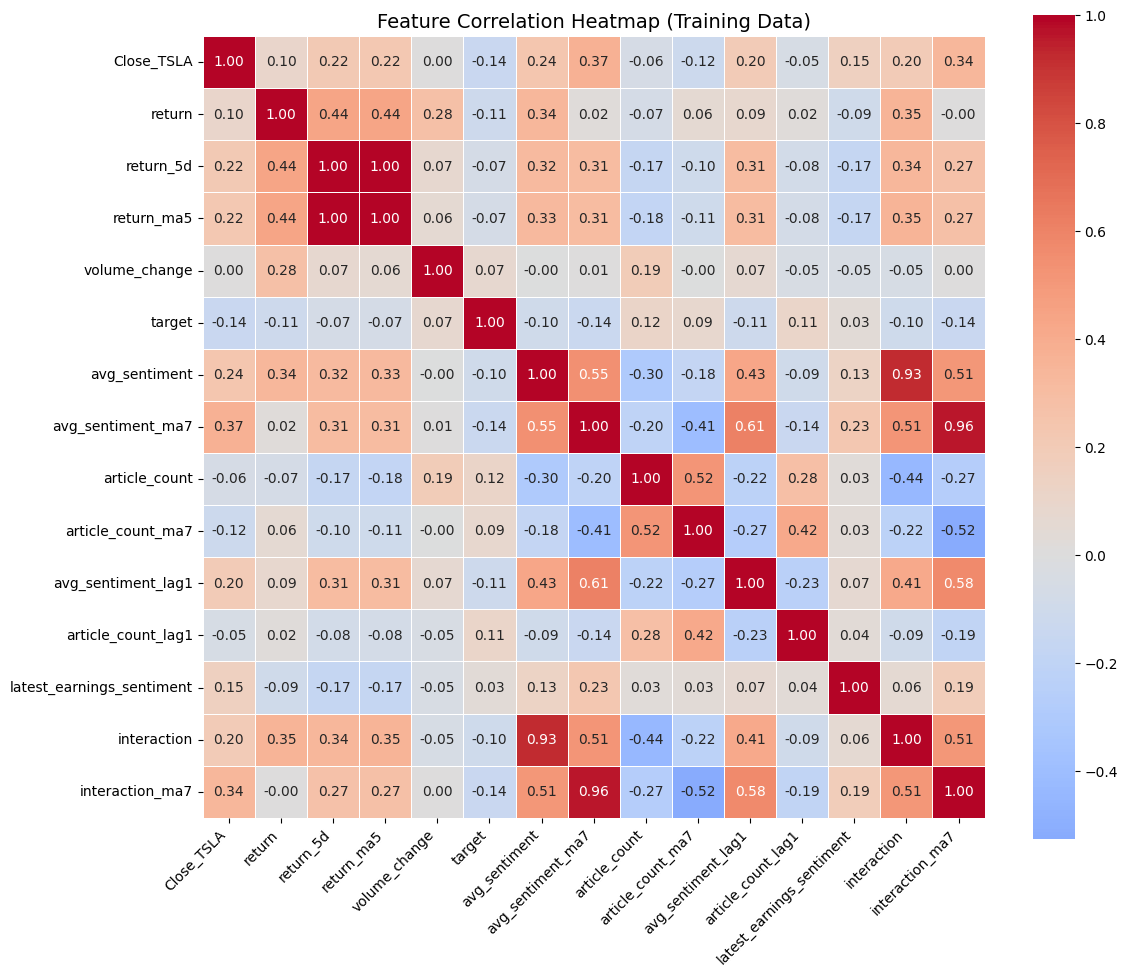

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only (including target)
corr_matrix = full_train_df.corr(numeric_only=True)

# Set figure size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap (Training Data)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


As a minimum viable product, the first model to put forward is logistic regression.

It works well with linear patterns and less data which is the case for this data set.  It is also very interpretable.  It performs relatively well with an ROC AUC of ~0.57 indicating it does slightly better than random.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

features = [col for col in full_train_df.columns
            if col not in ['date', 'target']]

X_train = full_train_df[features]
y_train = full_train_df['target']

X_test = test_df[features]
y_test = test_df['target']


X_train = full_train_df[features].copy()
y_train = full_train_df['target']
X_test  = test_df[features].copy()
y_test  = test_df['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



# -----------------------------
# Fit Logistic Regression (L2 regularization)
# -----------------------------
clf = LogisticRegression(penalty='l2', solver='liblinear', max_iter=500)
clf.fit(X_train_scaled, y_train)

# -----------------------------
# Predict Probabilities & Evaluate
# -----------------------------
y_pred_prob = clf.predict_proba(X_test_scaled)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test ROC AUC: {auc:.3f}")

# Optional: classification at 0.5 threshold
y_pred_class = (y_pred_prob >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))


Test ROC AUC: 0.569
[[46 61]
 [37 81]]
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       107
           1       0.57      0.69      0.62       118

    accuracy                           0.56       225
   macro avg       0.56      0.56      0.55       225
weighted avg       0.56      0.56      0.56       225



I also attempted xgboost with some hyperparameter tuning, but this doesn't work as well as the logistic regression does.

My data characteristics:

-Small sample size (257 train, 225 test)

-High noise (stock prediction)

-Linear relationships (sentiment → price)

XGBoost is designed for:

-Large datasets (1000+ samples)

-Complex non-linear patterns

-Diverse, independent features

My data suits linear models better.

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb

# -----------------------------
# Features & targets
# -----------------------------
features = [col for col in train_df.columns if col not in ['date', 'target']]

X_train = train_df[features].copy()
y_train = train_df['target']

X_val = val_df[features].copy()
y_val = val_df['target']

X_test = test_df[features].copy()
y_test = test_df['target']

# -----------------------------
# Define parameter grid for random search
# -----------------------------
param_grid = {
    'n_estimators': [150, 200, 300],  # More trees
    'max_depth': [2, 3, 4],
    'learning_rate': [0.08, 0.1, 0.12],  # Lower rates with more trees
    'subsample': [0.7, 0.8, 0.9],  # Regularization
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'reg_lambda': [0.5, 1, 1.5]  # L2 regularization
}
# xgb_model_final = xgb.XGBClassifier(
#     n_estimators=100,
#     max_depth=3,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     eval_metric='logloss'
# )

# -----------------------------
# Randomized search with duplicate prevention
# -----------------------------
n_iter = 100
best_auc = -np.inf
best_params = None
tried_params = set()  # Track tried combinations

attempts = 0
max_attempts = n_iter * 3  # Prevent infinite loop

while len(tried_params) < n_iter and attempts < max_attempts:
    # Randomly sample parameters
    params = {k: np.random.choice(v) for k, v in param_grid.items()}

    # Convert to hashable tuple to check if already tried
    params_tuple = tuple(sorted(params.items()))

    if params_tuple in tried_params:
        attempts += 1
        continue  # Skip, already tried

    tried_params.add(params_tuple)
    attempts += 1

    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        eval_metric='logloss',
        **params
    )
    xgb_model.fit(X_train, y_train)

    # Predict on validation set
    y_val_prob = xgb_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_prob)

    i = len(tried_params)
    # print(f"Iter {i}/{n_iter} | AUC: {auc:.3f} | Params: {params}")

    if auc > best_auc:
        best_auc = auc
        best_params = params

print(f"\nBest params from validation: {best_params} with ROC AUC: {best_auc:.3f}")

# -----------------------------
# Retrain on full training set (train + validation) with best params
# -----------------------------
X_full_train = full_train_df[features].copy()
y_full_train = full_train_df['target']

xgb_model_final = xgb.XGBClassifier(
    eval_metric='logloss',
    **best_params
)
xgb_model_final.fit(X_full_train, y_full_train)

# -----------------------------
# Evaluate on test set
# -----------------------------
y_pred_prob_xgb = xgb_model_final.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"\nTest ROC AUC: {auc:.3f}")

y_pred_class_xgb = (y_pred_prob_xgb >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred_class_xgb))
print(classification_report(y_test, y_pred_class_xgb))



Best params from validation: {'n_estimators': np.int64(200), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.1), 'subsample': np.float64(0.7), 'colsample_bytree': np.float64(0.9), 'min_child_weight': np.int64(1), 'gamma': np.float64(0.05), 'reg_alpha': np.float64(0.01), 'reg_lambda': np.float64(1.5)} with ROC AUC: 0.600

Test ROC AUC: 0.521
[[67 40]
 [59 59]]
              precision    recall  f1-score   support

           0       0.53      0.63      0.58       107
           1       0.60      0.50      0.54       118

    accuracy                           0.56       225
   macro avg       0.56      0.56      0.56       225
weighted avg       0.57      0.56      0.56       225



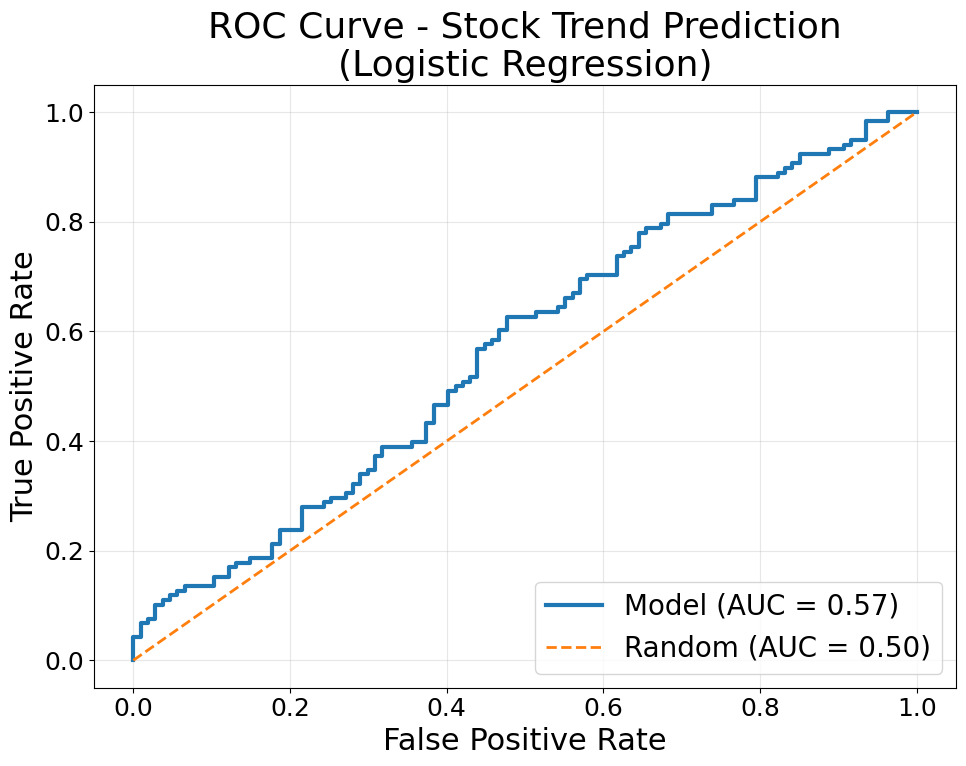

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# -----------------------------
# Global font scaling
# -----------------------------
plt.rcParams.update({
    'font.size': 18,          # base font
    'axes.titlesize': 26,     # title
    'axes.labelsize': 22,     # axis labels
    'xtick.labelsize': 18,    # x ticks
    'ytick.labelsize': 18,    # y ticks
    'legend.fontsize': 20     # legend
})

# Get predicted probabilities
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 8))  # larger canvas

plt.plot(
    fpr,
    tpr,
    linewidth=3,
    label=f'Model (AUC = {roc_auc:.2f})'
)

plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    linewidth=2,
    label='Random (AUC = 0.50)'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stock Trend Prediction\n(Logistic Regression)')

plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output_plots/roc_curve.png', dpi=300)
plt.show()


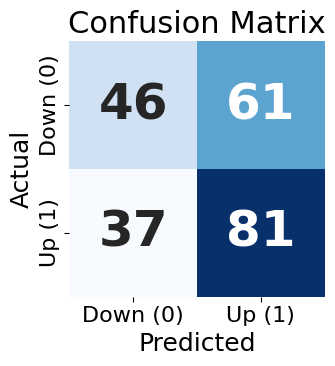

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predictions
y_pred = (y_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))  # compact so boxes stay small

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    square=True,  # keeps cells square
    annot_kws={
        "size": 36,        # large numbers
        "weight": "bold"
    }
)

# Clean axis labels
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('Actual', fontsize=18)

# Clear class labels for presentation
ax.set_xticklabels(['Down (0)', 'Up (1)'], fontsize=16)
ax.set_yticklabels(['Down (0)', 'Up (1)'], fontsize=16)

plt.title('Confusion Matrix', fontsize=22)

plt.tight_layout()
plt.savefig('output_plots/confusion_matrix_counts.png', dpi=300)
plt.show()


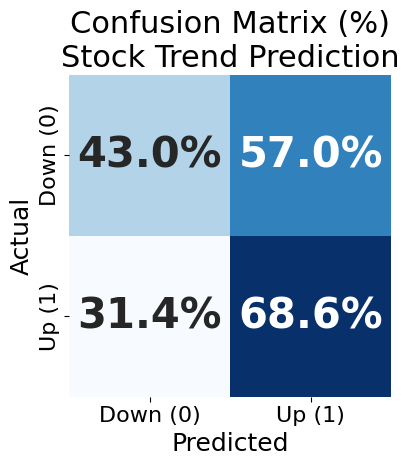

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions
y_pred = (y_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to row percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))

ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt='.1%',
    cmap='Blues',
    cbar=False,
    square=True,
    annot_kws={"size": 30, "weight": "bold"}
)

ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('Actual', fontsize=18)
ax.set_xticklabels(['Down (0)', 'Up (1)'], fontsize=16)
ax.set_yticklabels(['Down (0)', 'Up (1)'], fontsize=16)

plt.title('Confusion Matrix (%)\nStock Trend Prediction', fontsize=22)

plt.tight_layout()
plt.savefig('output_plots/confusion_matrix_percent.png', dpi=300)
plt.show()


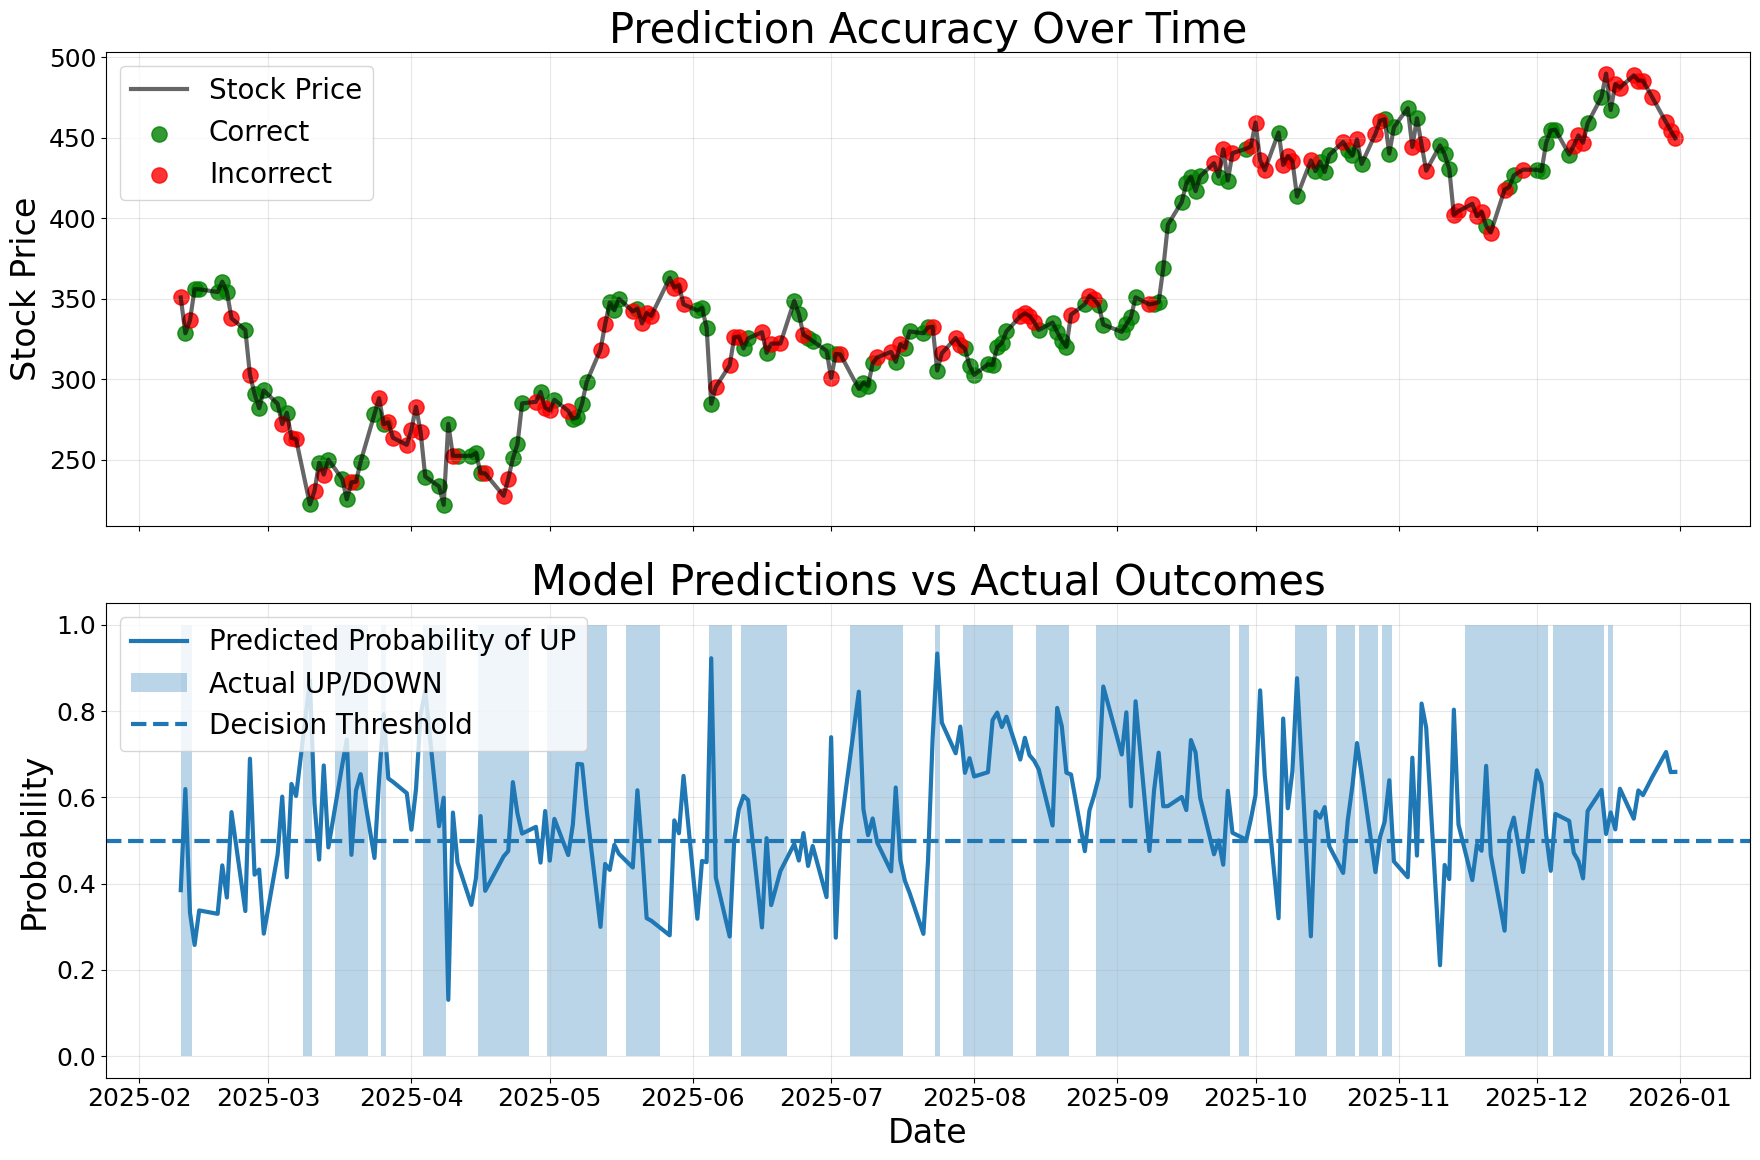

In [19]:
import matplotlib.pyplot as plt

# -----------------------------
# Global font scaling
# -----------------------------
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 30,
    'axes.labelsize': 24,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 20
})

# Create results dataframe
results = test_df.copy()
results['predicted_prob'] = y_prob
results['predicted_class'] = y_pred
results['actual_class'] = y_test

# Bigger overall canvas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# -----------------------------
# Top: Stock price with prediction correctness
# -----------------------------
ax1.plot(
    results['date'],
    results['Close_TSLA'],
    color='black',
    alpha=0.6,
    linewidth=3,
    label='Stock Price'
)

correct = results[results['predicted_class'] == results['actual_class']]
incorrect = results[results['predicted_class'] != results['actual_class']]

ax1.scatter(
    correct['date'],
    correct['Close_TSLA'],
    color='green',
    s=120,           # larger markers
    alpha=0.8,
    label='Correct'
)

ax1.scatter(
    incorrect['date'],
    incorrect['Close_TSLA'],
    color='red',
    s=120,
    alpha=0.8,
    label='Incorrect'
)

ax1.set_ylabel('Stock Price')
ax1.set_title('Prediction Accuracy Over Time')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# -----------------------------
# Bottom: Prediction probability
# -----------------------------
ax2.plot(
    results['date'],
    results['predicted_prob'],
    linewidth=3,
    label='Predicted Probability of UP'
)

ax2.fill_between(
    results['date'],
    0,
    results['actual_class'],
    alpha=0.3,
    step='mid',
    label='Actual UP/DOWN'
)

ax2.axhline(
    y=0.5,
    linestyle='--',
    linewidth=3,
    label='Decision Threshold'
)

ax2.set_xlabel('Date')
ax2.set_ylabel('Probability')
ax2.set_title('Model Predictions vs Actual Outcomes')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output_plots/predictions_over_time.png', dpi=300)
plt.show()


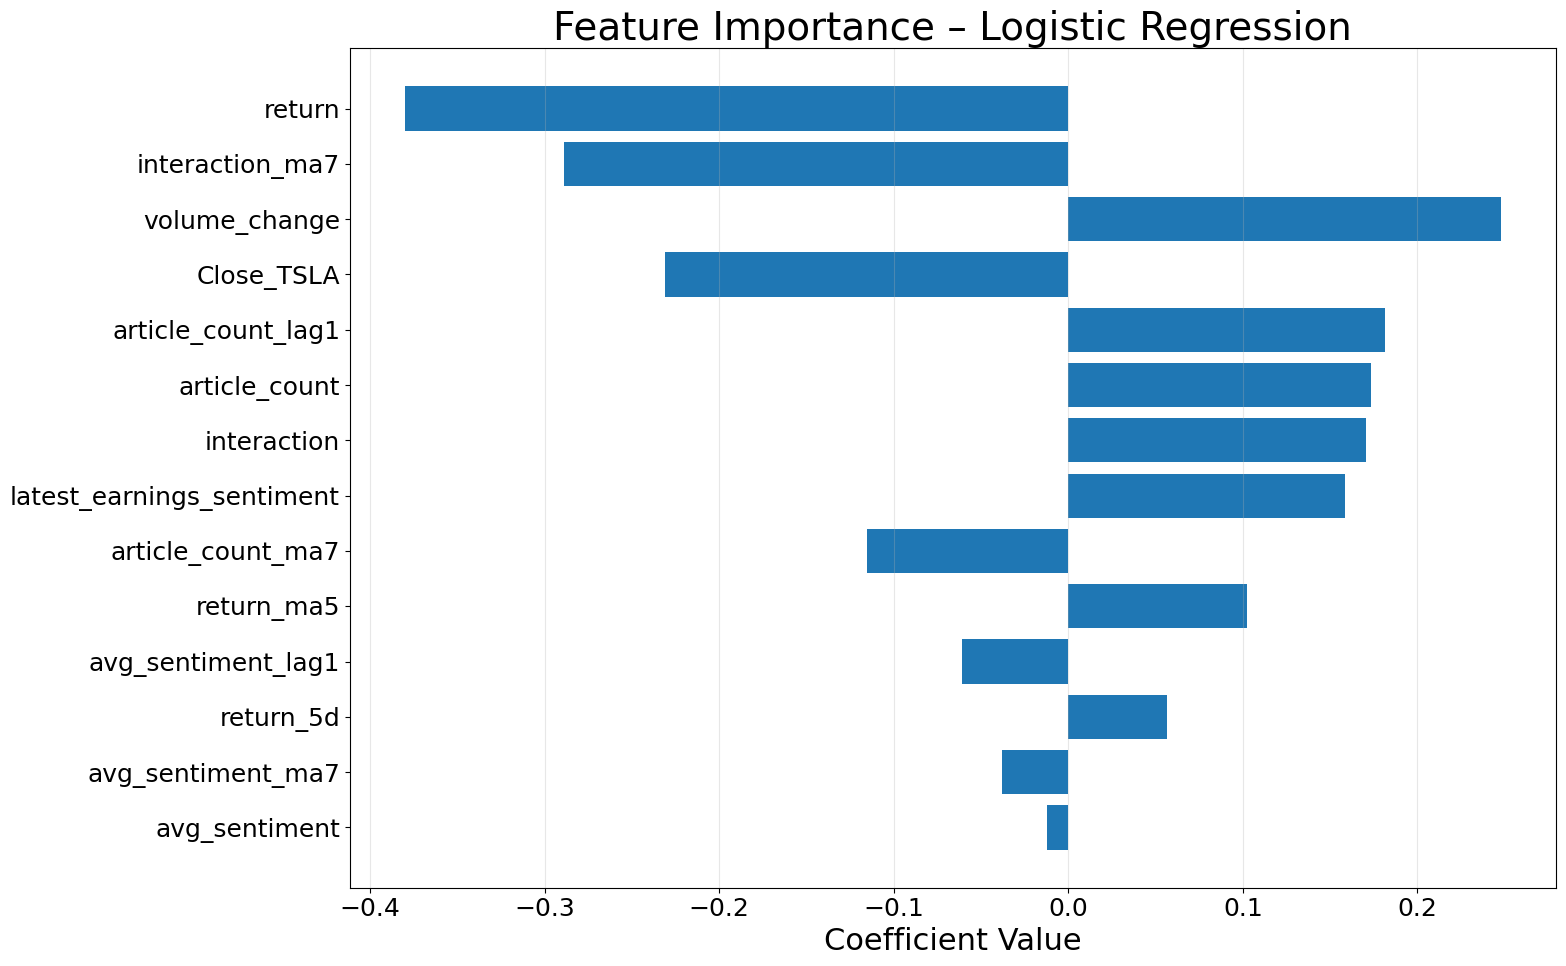

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Global font scaling
# -----------------------------
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 28,
    'axes.labelsize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.coef_[0]
}).sort_values('importance', key=abs, ascending=True)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(16, 10))  # bigger canvas for slides

plt.barh(
    feature_importance['feature'],
    feature_importance['importance'],
    height=0.8   # thicker bars
)

plt.xlabel('Coefficient Value')
plt.title('Feature Importance – Logistic Regression')

plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('output_plots/feature_importance.png', dpi=300)
plt.show()
